## load libraries and model


In [1]:
import os.path as osp, os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
import torch, polars as pl
from gnnepcsaft.data.graphdataset import ThermoMLDataset, Ramirez, ThermoMLpara
from gnnepcsaft.train.utils import create_model
from gnnepcsaft.train.utils import calc_deg
from gnnepcsaft.data.graph import from_InChI
from gnnepcsaft.configs.default import get_config
import pickle, numpy as np
from rdkit import Chem
from gnnepcsaft.demo.utils import plotdata, loadckp, model_para_fn, datacsv, plotparams

torch.cuda.is_available()

False

In [2]:
ra_loader = Ramirez("gnnepcsaft/data/ramirez2022")
ra_para = {}
for graph in ra_loader:
    inchi, para = graph.InChI, graph.para.view(-1, 3).round(decimals=2)
    ra_para[inchi] = para.tolist()[0]
tml_loader = ThermoMLpara("gnnepcsaft/data/thermoml")
tml_para = {}
for graph in tml_loader:
    inchi, para = graph.InChI, graph.para.view(-1, 3).round(decimals=2)
    tml_para[inchi] = para.tolist()[0]
path = osp.join("gnnepcsaft/data", "thermoml")
testloader = ThermoMLDataset(path)
device = torch.device("cpu")

In [3]:
config = get_config()
config.model = "PNAL"
config.propagation_depth = 2
config.hidden_dim = 128
config.num_mlp_layers = 1
config.pre_layers = 1
config.post_layers = 3
config.skip_connections = False
config.add_self_loops = False
model_dtype = torch.float64

# Create and initialize the network.
deg_model1 = calc_deg("ramirez", "gnnepcsaft/")
model1 = create_model(config, deg_model1).to(device, model_dtype)
# Set up checkpointing of the model.
ckp_path = "gnnepcsaft/train/checkpoints/model6-epoch=170939-mape_den=0.0102.ckpt"
loadckp(ckp_path, model1)

In [4]:
config = get_config()
config.model = "PNAL"
config.propagation_depth = 6
config.hidden_dim = 64
config.pre_layers = 1
config.post_layers = 1
config.num_mlp_layers = 1
config.skip_connections = True
config.add_self_loops = True
model_dtype = torch.float64

# Create and initialize the network.
deg_model2 = calc_deg("ramirez", "gnnepcsaft/")
model2 = create_model(config, deg_model2).to(device, model_dtype)
# Set up checkpointing of the model.
ckp_path = "gnnepcsaft/train/checkpoints/model8_2_2-epoch=31249-mape_den=0.0172.ckpt"
loadckp(ckp_path, model2)

## evaluations


In [5]:
model1_para, model1_array = model_para_fn(model1)
model2_para, model2_array = model_para_fn(model2)

/workspaces/ePC-SAFT/gnnepcsaft/gnnepcsaft/demo/utils.py:253: RuntimeWarning: Mean of empty slice.
  mden, mvp = mden_array.mean(), mvp_array.mean()
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
data2 = datacsv(model2_para)
data1 = datacsv(model1_para)
model1data = pl.DataFrame(data1)
model2data = pl.DataFrame(data2)
model1data.write_csv("../model1.csv")
model2data.write_csv("../model2.csv")

## plotting


#### Parameters for model 1 ####
[ 12.79475814   4.25755656 266.43872496]
#### Parameters for model 2 ####
[ 11.02581333   4.36644738 298.79876896]


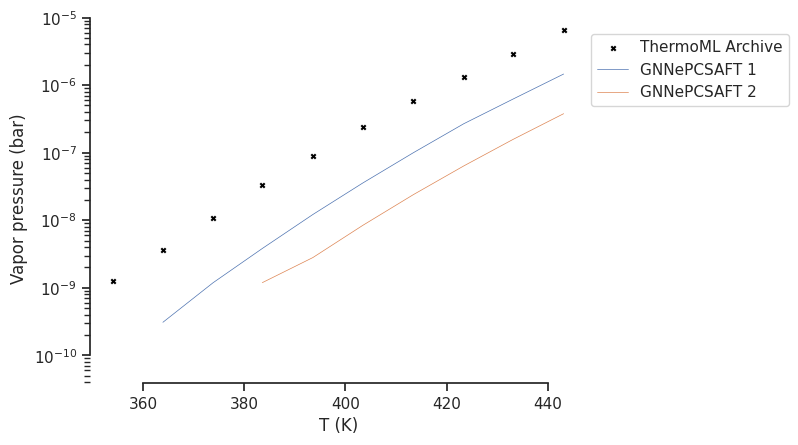

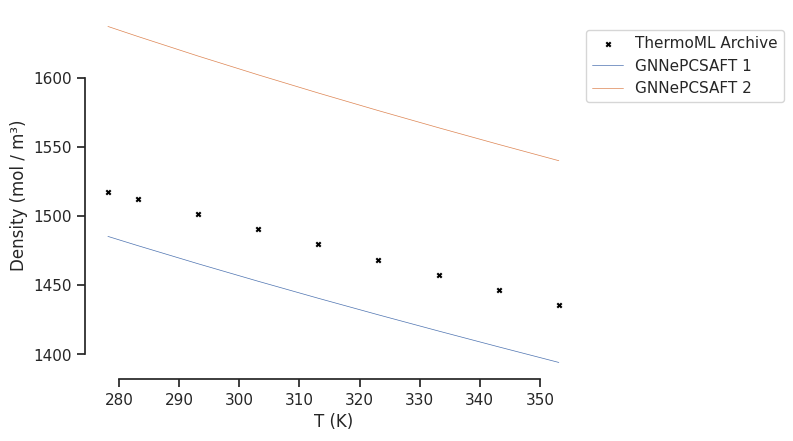

display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


In [10]:
inchi = "InChI=1S/C37H68O8/c1-9-17-21-29(13-5)33(38)42-25-37(26-43-34(39)30(14-6)22-18-10-2,27-44-35(40)31(15-7)23-19-11-3)28-45-36(41)32(16-8)24-20-12-4/h29-32H,9-28H2,1-8H3"
molecule_name = "UNKNOWN"
plotdata(inchi, molecule_name, [model1, model2])

In [ ]:
smiles = ["C" * i + "(=O)OCC" for i in range(1, 100)]

In [ ]:
smiles = ["C" * i for i in range(1, 100)]

In [8]:
smiles = ["C" * i + "O" for i in range(1, 100)]

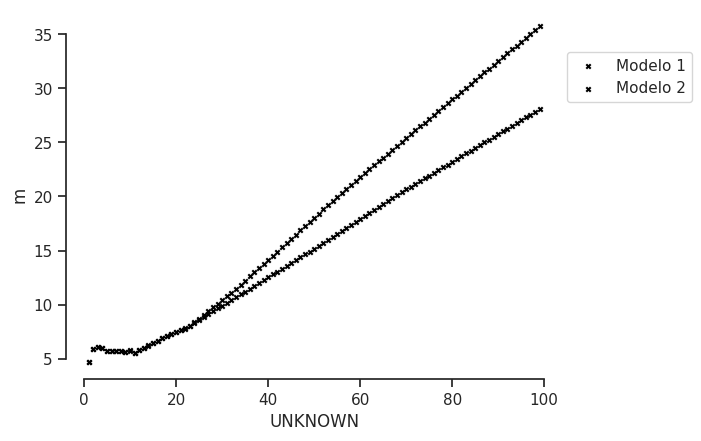

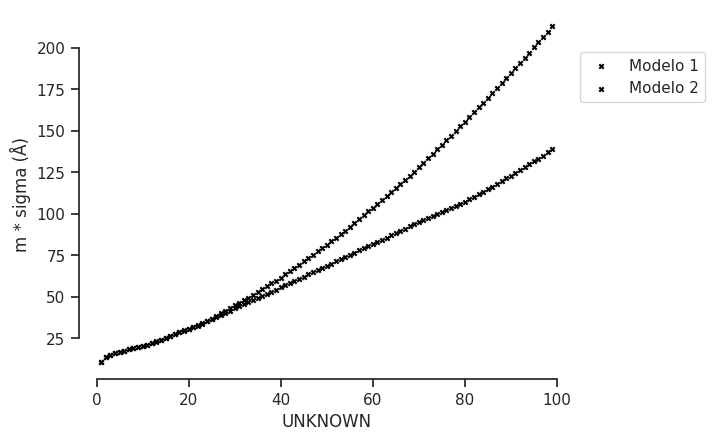

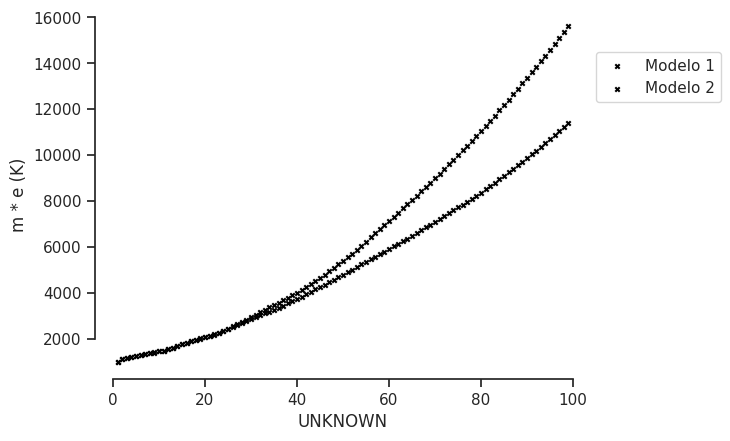

In [9]:
plotparams(smiles, [model1, model2], "UNKNOWN")

In [ ]:
test_inchis = []
for gh in testloader:
    test_inchis.append(gh.InChI)
inchis = []
for smile in smiles:
    mol = Chem.MolFromSmiles(smile)
    inchi = Chem.MolToInchi(mol)
    if inchi in test_inchis:
        inchis.append(inchi)

In [ ]:
inchis